In [528]:
import numpy
import math
from matplotlib import pyplot
%matplotlib inline

In [529]:
#Load Functions and Classes used for Panel Method
%run resources/resources.ipynb

In [530]:
# load Data Files for Foil with Flap
with open('resources/MainFoil_N=100.csv', 'r') as infile:
    x_main, y_main = numpy.loadtxt(infile, delimiter=',', dtype=float, unpack=True)
    
with open('resources/FlapFoil_N=100.csv', 'r') as infile:
    x_flap, y_flap = numpy.loadtxt(infile, delimiter=',', dtype=float, unpack=True)

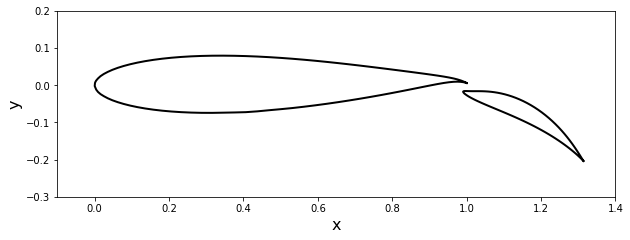

In [531]:
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.2);

*Since we the data has already been discretized, we can just use the end of the define panels function*

In [532]:
def disc_define_panels(x , y):
    N = len(x)-1
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [533]:
N = 100
main_panels = disc_define_panels(x_main, y_main)
flap_panels = disc_define_panels(x_flap, y_flap)
panels = numpy.append(main_panels, flap_panels)

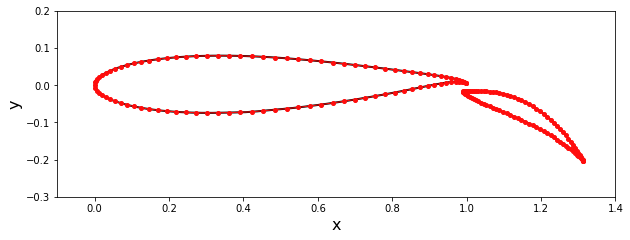

In [534]:
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.plot([panel.xc for panel in main_panels], [panel.yc for panel in main_panels],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.plot([panel.xc for panel in flap_panels], [panel.yc for panel in flap_panels],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.2);

Modify Matrix Equations from previous sections/resources file to include Flap Geometry

In [535]:
def total_build_matrix(panels, A_source, B_vortex):
    N = panels.size
    #Matrix creation and setup
    A = numpy.empty((N+2, N+2), dtype=float)
    A[:N, :N] = A_source
    A_t = numpy.empty((N, N+2), dtype=float)
    A_t[:N,:N] = B_vortex
    A_v = numpy.empty((N,2), dtype=float)
    
    
    A_t_1, A_t_2 = numpy.zeros((N), dtype=float), numpy.zeros((N), dtype=float)
    for i, panels_i in enumerate(panels):
        A_t_1[i] = numpy.sum(A_source[i,:int(N/2)])
        A_t_2[i] = numpy.sum(A_source[i,int(N/2):])
    
    A_t[:, -2] = -A_t_1
    A_t[:, -1] = -A_t_2
    
    
    for i, panel_i in enumerate(panels):
        A_v[i,0] = numpy.sum(B_vortex[i,:int(N/2)])
        A_v[i,1] = numpy.sum(B_vortex[i,int(N/2):])
    
    A[:N, N:] = A_v
    
    A_kutta = numpy.empty((2,N+2), dtype=float)
    A_kutta[0,:] = A_t[0,:] + A_t[int(N/2-1),:]
    A_kutta[1,:] = A_t[int(N/2),:] + A_t[-1,:]
    
    A[-2:,:] = A_kutta
    
    return A

In [536]:
def total_build_rhs(panels, freestream):
    N = panels.size
    b = numpy.empty(N+2,dtype=float)
   
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    
    #Kutta Condition for freestream
    b[-2] = -freestream.u_inf*(numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[int(N/2-1)].beta) )
    b[-1] = -freestream.u_inf*(numpy.sin(freestream.alpha-panels[int(N/2)].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    
    return b

Now that our functions are defined we can use them as well as the equations from lesson 10 to build our total system

In [537]:
#Use the functions previously defined found in the resources folder.
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

In [538]:
A = total_build_matrix(panels, A_source, B_vortex)

In [539]:
b = total_build_rhs(panels, freestream)

In [540]:
strengths = numpy.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = strengths[i]

gamma_main = strengths[-2]
gamma_flap = strengths[-1]

gamma = numpy.append(gamma_main, gamma_flap)

## Compute Tangential Velocity using function from Lesson 10 modified for flap

In [541]:
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [542]:
compute_pressure_coefficient(panels, freestream)

In [543]:
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]

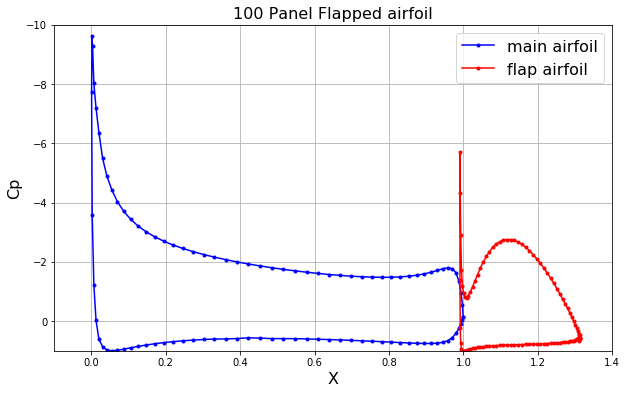

In [544]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('X', fontsize=16)
pyplot.ylabel('Cp', fontsize=16)
pyplot.plot([panel.xc for panel in main_panels],
            [panel.cp for panel in main_panels],
           label='main airfoil', color='b', linestyle='-', marker='o', markersize=3)
pyplot.plot([panel.xc for panel in flap_panels],
            [panel.cp for panel in flap_panels],
           label='flap airfoil', color='r', linestyle='-', marker='o', markersize=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(1.0, -10.0)
pyplot.title('100 Panel Flapped airfoil', fontsize=16);

## Open edX questions:

What is the pressure coefficient on the 3rd panel on the main airfoil?

In [545]:
print('Cp on main 3rd panel: ', main_panels[2].cp)

Cp on main 3rd panel:  -0.955701172981


What is the pressure coefficient on the 10th panel on the flap airfoil?

In [546]:
print('Cp on flap 10th panel: ', flap_panels[9].cp)

Cp on flap 10th panel:  -0.279918398369


What is the value of lift?

In [547]:
L100 = 0
for panel in panels:
    L100 -= panel.cp*panel.length*math.sin(panel.beta)
L_theory = 3.7386
err100 = abs(L_theory-L100)
print('Value of lift = ', L100)

Value of lift =  3.69771447686


What is the value of drag?

In [548]:
D100 = 0
for panel in panels:
    D100 += panel.cp*panel.length*math.cos(panel.beta)
    
print('Value of drag = ', D100)    

Value of drag =  0.0107914032459


## Run the program again with 200 panels on both main and flap airfoils. What is the percentage of improvement of the absolute error in the value of lift?

In [549]:
with open('resources/MainFoil_N=200.csv', 'r') as infile:
    x_main, y_main = numpy.loadtxt(infile, delimiter=',', dtype=float, unpack=True)
    
with open('resources/FlapFoil_N=200.csv', 'r') as infile:
    x_flap, y_flap = numpy.loadtxt(infile, delimiter=',', dtype=float, unpack=True)

In [550]:
N = 200
main_panels = disc_define_panels(x_main, y_main)
flap_panels = disc_define_panels(x_flap, y_flap)
panels = numpy.append(main_panels, flap_panels)

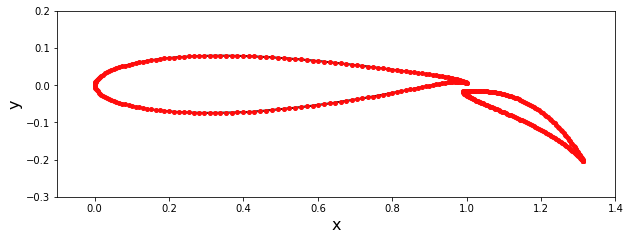

In [551]:
#Check to ensure that the data loaded properly and the number of panels has changed
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.plot([panel.xc for panel in main_panels], [panel.yc for panel in main_panels],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.plot([panel.xc for panel in flap_panels], [panel.yc for panel in flap_panels],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.2);

In [552]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

In [553]:
A = total_build_matrix(panels, A_source, B_vortex)

In [554]:
b = total_build_rhs(panels, freestream)

In [555]:
strengths = numpy.linalg.solve(A,b)

for i, panel in enumerate(panels):
    panel.sigma = strengths[i]

gamma_main = strengths[-2]
gamma_flap = strengths[-1]

gamma = numpy.append(gamma_main, gamma_flap)

In [556]:
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [557]:
compute_pressure_coefficient(panels, freestream)

In [558]:
N = panels.size
main_panels, flap_panels = panels[:int(N/2)], panels[int(N/2):]

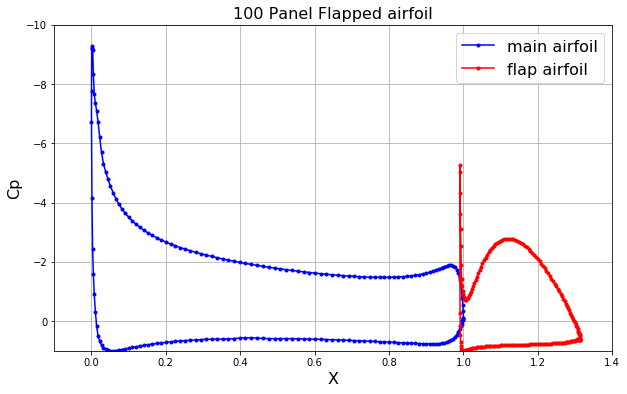

In [559]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('X', fontsize=16)
pyplot.ylabel('Cp', fontsize=16)
pyplot.plot([panel.xc for panel in main_panels],
            [panel.cp for panel in main_panels],
           label='main airfoil', color='b', linestyle='-', marker='o', markersize=3)
pyplot.plot([panel.xc for panel in flap_panels],
            [panel.cp for panel in flap_panels],
           label='flap airfoil', color='r', linestyle='-', marker='o', markersize=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(1.0, -10.0)
pyplot.title('100 Panel Flapped airfoil', fontsize=16);

In [560]:
L200 = 0
for panel in panels:
    L200 -= panel.cp*panel.length*math.sin(panel.beta)
err200 = abs(L_theory-L200)
print('Value of lift = ', L200)

Value of lift =  3.71843390868


In [561]:
err_improve = abs(err200-err100)/err100 * 100
print('Error improvement = ', err_improve, '%')

Error improvement =  50.6766949023 %


# Wetzinger's Test Case

In [607]:
with open('resources/NACA23012_MainFoil.csv', 'r') as infile:
    x_main, y_main = numpy.loadtxt(infile, delimiter=',', dtype=float, unpack=True)
    
with open('resources/NACA23012_FlapFoil.csv', 'r') as infile:
    x_flap, y_flap = numpy.loadtxt(infile, delimiter=',', dtype=float, unpack=True)

In [608]:
#Center point of rotation for the flap
xc, yc = 1.03, -0.054
#Angle to rotate flap
theta = 20

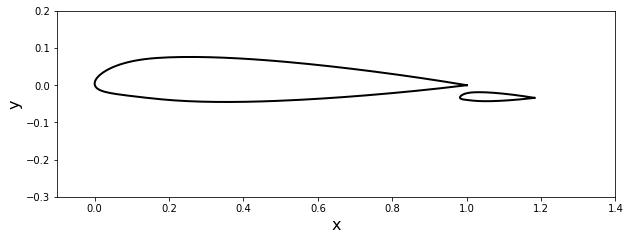

In [609]:
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_flap, y_flap, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.2);

In [610]:
def rotation(x_flap, y_flap, xc, yc, theta):
    theta = math.radians(theta)
    x_rot = (x_flap - xc)*math.cos(theta) + (y_flap - yc)*math.sin(theta) + xc
    y_rot = -(x_flap - xc)*math.sin(theta) + (y_flap - yc)*math.cos(theta) + yc
    
    return x_rot, y_rot

In [611]:
x_rot, y_rot = rotation(x_flap, y_flap, xc, yc, theta)

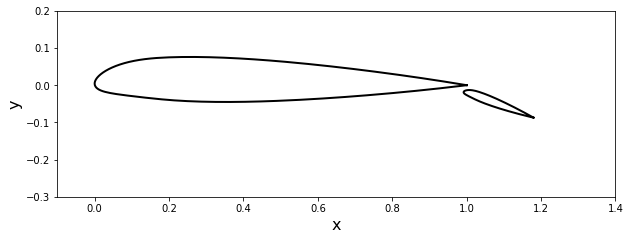

In [612]:
#Check the rotation
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_rot, y_rot, color='k', linewidth=2, linestyle='-')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.2);

In [613]:
N = len(x_main)-1
main_panels = disc_define_panels(x_main, y_main)
flap_panels = disc_define_panels(x_rot, y_rot)
panels = numpy.append(main_panels, flap_panels)

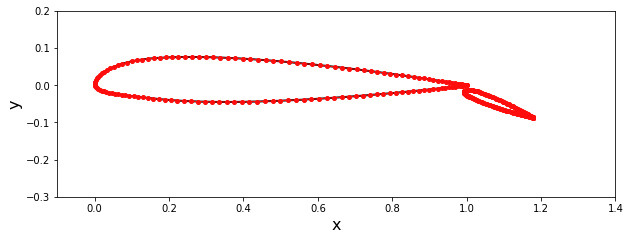

In [614]:
width = 10
plt.figure(figsize=(width,width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_main, y_main, color='k', linewidth=2, linestyle='-')
plt.plot(x_rot, y_rot, color='k', linewidth=2, linestyle='-')
plt.plot([panel.xc for panel in main_panels], [panel.yc for panel in main_panels],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.plot([panel.xc for panel in flap_panels], [panel.yc for panel in flap_panels],
         color='#FF0D0D', linewidth=1, marker='o', markersize=4)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.4)
plt.ylim(-0.3, 0.2);

In [615]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

## Bisection Method Question 1

In [620]:
#Information Setup
alpha_1 = -14
alpha_2 = 14 
alpha = (alpha_1 + alpha_2)/2
u_inf = 1.0

In [621]:
#Setting up Iterations
delta = 1
err = 0.001

In [622]:
#Using above equations and methods to check for when lift = 0 at given AOA
while delta > err:
    freestream = Freestream(u_inf, alpha)
    A = total_build_matrix(panels, A_source, B_vortex)
    b = total_build_rhs(panels, freestream)
    
    strengths = numpy.linalg.solve(A,b)

    for i, panel in enumerate(panels):
        panel.sigma = strengths[i]

    gamma_main = strengths[-2]
    gamma_flap = strengths[-1]
    gamma = numpy.append(gamma_main, gamma_flap)
    
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    
    L = 0
    for panel in panels:
        L -= panel.cp*panel.length*math.sin(panel.beta)
    
    if L > 0.0:
        alpha_1 = alpha
    if L < 0.0:
        alpha_2 = alpha
    delta = abs(alpha_1 - alpha_2)
    alpha = (alpha_1 + alpha_2) / 2

In [623]:
print('AOA for 0 Lift =', alpha)

AOA for 0 Lift = 13.99957275390625


## Bisection Method Question 2

In [575]:
alpha = 0 
theta_flap_1 = -20
theta_flap_2 = 0
theta_flap = (theta_flap_1+theta_flap_2)/2
freestream = Freestream(u_inf, alpha)
delta = 1
err = 0.001

In [576]:
while delta > err:
    x_rot, y_rot = rotation(x_flap, y_flap, xc, yc, theta_flap)
    flap_panels = disc_define_panels(x_rot, y_rot)
    panels = panels = numpy.append(main_panels, flap_panels)
    
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    
    A = total_build_matrix(panels, A_source, B_vortex)
    b = total_build_rhs(panels, freestream)
    
    strengths = numpy.linalg.solve(A,b)

    for i, panel in enumerate(panels):
        panel.sigma = strengths[i]

    gamma_main = strengths[-2]
    gamma_flap = strengths[-1]
    gamma = numpy.append(gamma_main, gamma_flap)
    
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    
    L = 0
    for panel in panels:
        L -= panel.cp*panel.length*math.sin(panel.beta)
    
    if L > 0.0:
        theta_flap_1 = theta_flap
    if L < 0.0:
        theta_flap_2 = theta_flap
    delta = abs(theta_flap_1-theta_flap_2)
    theta_flap = (theta_flap_1+theta_flap_2)/2

In [577]:
print('Angle of flaps for 0 Lift =', theta_flap)

Angle of flaps for 0 Lift = -19.99969482421875


## Bisection Method Question 3

In [578]:
alpha = 4
freestream = Freestream(u_inf, alpha)

In [583]:
def lift_changing_flap_angle(theta_flap, x_flap, y_flap, xc, yc, main_panels, freestream):
    x_rot, y_rot = rotation(x_flap, y_flap, xc, yc, theta_flap)
    flap_panels = disc_define_panels(x_rot, y_rot)
    panels = panels = numpy.append(main_panels, flap_panels)
    
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    
    A = total_build_matrix(panels, A_source, B_vortex)
    b = total_build_rhs(panels, freestream)
    
    strengths = numpy.linalg.solve(A,b)

    for i, panel in enumerate(panels):
        panel.sigma = strengths[i]

    gamma_main = strengths[-2]
    gamma_flap = strengths[-1]
    gamma = numpy.append(gamma_main, gamma_flap)
    
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    
    L = 0
    for panel in panels:
        L -= panel.cp*panel.length*math.sin(panel.beta)
        
    return L

In [584]:
L_0 = lift_changing_flap_angle(0, x_flap, y_flap, xc, yc, main_panels, freestream)
L_5 = lift_changing_flap_angle(5, x_flap, y_flap, xc, yc, main_panels, freestream)
L_10 = lift_changing_flap_angle(10, x_flap, y_flap, xc, yc, main_panels, freestream)
L_15 = lift_changing_flap_angle(15, x_flap, y_flap, xc, yc, main_panels, freestream)

In [585]:
delta_5 = (1 - (numpy.sqrt(L_0/L_5)))*100
delta_10 = (1 - (numpy.sqrt(L_0/L_10)))*100
delta_15 = (1 - (numpy.sqrt(L_0/L_15)))*100

In [586]:
print('Percent slower aircraft can fly with flap angle 5:', delta_5)
print('Percent slower aircraft can fly with flap angle 10:', delta_10)
print('Percent slower aircraft can fly with flap angle 15:', delta_15)

Percent slower aircraft can fly with flap angle 5: 14.5141136357
Percent slower aircraft can fly with flap angle 10: 24.2124090158
Percent slower aircraft can fly with flap angle 15: 31.2809103274
